In [16]:
%matplotlib inline

# StackingClassifier: Simple stacking

An ensemble-learning meta-classifier for stacking.

> from mlxtend.classifier import StackingClassifier

# Overview

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble.
The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

![](./StackingClassifier_files/stackingclassification_overview.png)

The algorithm can be summarized as follows (source: [1]):
    
![](./StackingClassifier_files/stacking_algorithm.png)

**Please note that this type of Stacking is prone to overfitting due to information leakage. The related [StackingCVClassifier.md](StackingCVClassifier.md) does not derive the predictions for the 2nd-level classifier from the same datast that was used for training the level-1 classifiers and is recommended instead.**

### References


- [1] Tang, J., S. Alelyani, and H. Liu. "[Data Classification: Algorithms and Applications.](https://books.google.com/books?id=nwQZCwAAQBAJ&lpg=PA500&dq=stacking%20classifier%20subsets&pg=PA499#v=onepage&q&f=false)" Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
- [2] Wolpert, David H. "[Stacked generalization.](http://www.sciencedirect.com/science/article/pii/S0893608005800231)" Neural networks 5.2 (1992): 241-259.
- [3] Marios Michailidis (2017), StackNet, StackNet Meta Modelling Framework, https://github.com/kaz-Anova/StackNet

## Example 1 - Simple Stacked Classification

In [17]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [18]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


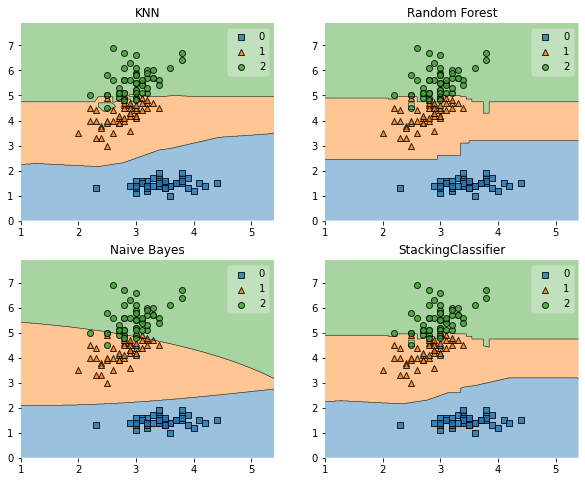

In [19]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

## Example 2 - Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting `use_probas=True`. If `average_probas=True`, the probabilities of the level-1 classifiers are averaged, if `average_probas=False`, the probabilities are stacked (recommended). For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

- classifier 1: [0.2, 0.5, 0.3]
- classifier 2: [0.3, 0.4, 0.4]

If `average_probas=True`, the meta-features would be:

- [0.25, 0.45, 0.35]

In contrast, using `average_probas=False` results in k features where, k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

- [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]


In [20]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.92 (+/- 0.02) [StackingClassifier]


## Example 3 - Stacked Classification and GridSearch

The stack allows tuning hyper parameters of the base and meta models! A full list of tunable parameters can be obtained via `estimator.get_params().keys()`.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In case we are planning to use a regression algorithm multiple times, all we need to do is to add an additional number suffix in the parameter grid as shown below:

In [22]:
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestcla

**Note**

The `StackingClassifier` also enables grid search over the `classifiers` argument. When there are level-mixed hyperparameters, GridSearchCV will try to replace hyperparameters in a top-down order, i.e., classifers -> single base classifier -> classifier hyperparameter. For instance,  given a hyperparameter grid such as

    params = {'randomforestclassifier__n_estimators': [1, 100],
    'classifiers': [(clf1, clf1, clf1), (clf2, clf3)]}
    
it will first use the instance settings of either (clf1, clf1, clf1) or (clf2, clf3). Then it will replace the `'n_estimators'` settings for a matching classifier based on `'randomforestclassifier__n_estimators': [1, 100]`.

## Example 4 - Stacking of Classifiers that Operate on Different Feature Subsets

The different level-1 classifiers can be fit to different subsets of features in the training dataset. The following example illustrates how this can be done on a technical level using scikit-learn pipelines and the `ColumnSelector`:

In [23]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LogisticRegression())

sclf.fit(X, y)

StackingClassifier(average_probas=False,
                   classifiers=[Pipeline(memory=None,
                                         steps=[('columnselector',
                                                 ColumnSelector(cols=(0, 2),
                                                                drop_axis=False)),
                                                ('logisticregression',
                                                 LogisticRegression(C=1.0,
                                                                    class_weight=None,
                                                                    dual=False,
                                                                    fit_intercept=True,
                                                                    intercept_scaling=1,
                                                                    l1_ratio=None,
                                                                    max_iter=100,
                       

## Example 5 - Using Pre-fitted Classifiers

Assume that we previously fitted our classifiers:

In [24]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

for clf in (clf1, clf2, clf3):
    clf.fit(X, y)

By setting `fit_base_estimators=False`, it will enforce `use_clones` to be False and the `StackingClassifier` will not re-fit these classifers to save computational time:

In [25]:
from mlxtend.classifier import StackingClassifier
import copy
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr, fit_base_estimators=False)

labels = ['KNN', 'Random Forest', 'Naive Bayes', 'StackingClassifier']

sclf.fit(X, y)

print('accuracy:', np.mean(y == sclf.predict(X)))

accuracy: 1.0


However, please note that `fit_base_estimators=False` is incompatible to any form of cross-validation that is done in e.g., `model_selection.cross_val_score` or `model_selection.GridSearchCV`, etc., since it would require the classifiers to be refit to the training folds. Thus, only use `fit_base_estimators=False` if you want to make a prediction directly without cross-validation.

## Example 6 -- ROC Curve with `decision_function`

Like other scikit-learn classifiers, the `StackingCVClassifier` has an `decision_function` method that can be used for plotting ROC curves. Note that the `decision_function` expects and requires the meta-classifier to implement a `decision_function`.

In [26]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target


# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]



RANDOM_SEED = 42


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()


sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)

**Using `predict_proba()`**

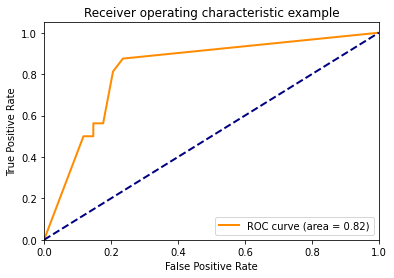

In [27]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Using `decision_function()`**

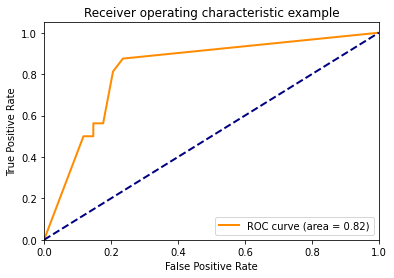

In [28]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# API

In [29]:
with open('../../api_modules/mlxtend.classifier/StackingClassifier.md', 'r') as f:
    print(f.read())

FileNotFoundError: [Errno 2] No such file or directory: '../../api_modules/mlxtend.classifier/StackingClassifier.md'